In [1]:
import os
import pandas as pd
import sys
from interpret import show
from interpret.provider import InlineProvider
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import train_test_split
from interpret.perf import RegressionPerf
from interpret.data import ClassHistogram, Marginal
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
in_file = r"E:\work\results\grid_search\metrics.csv"
in_file = os.path.abspath(in_file)
in_dir = os.path.dirname(in_file)
random_state = 42
test_size = 0.50

df = pd.read_csv(in_file)

df

,image,class,threshold,metric,value,data_dataset,model_activation,model_depth,model_in_channels,model_out_classes,model_residual_units,model_width,model_width_ratio,job_hash,epoch,loss,predict_time
0,bremen_000075_000019,road,0.5,iou,0.927125,cityscapes,piecewise_linear,8,3,19,2,50,1.4,025cb7327dfa11ba27fd6fafcec81e13,237,0.326670,611.571244
1,bremen_000075_000019,sidewalk,0.5,iou,0.860142,cityscapes,piecewise_linear,8,3,19,2,50,1.4,025cb7327dfa11ba27fd6fafcec81e13,237,0.326670,611.571244
2,bremen_000075_000019,building,0.5,iou,0.842418,cityscapes,piecewise_linear,8,3,19,2,50,1.4,025cb7327dfa11ba27fd6fafcec81e13,237,0.326670,611.571244
3,bremen_000075_000019,fence,0.5,iou,0.534923,cityscapes,piecewise_linear,8,3,19,2,50,1.4,025cb7327dfa11ba27fd6fafcec81e13,237,0.326670,611.571244
4,bremen_000075_000019,pole,0.5,iou,0.525356,cityscapes,piecewise_linear,8,3,19,2,50,1.4,025cb7327dfa11ba27fd6fafcec81e13,237,0.326670,611.571244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2628283,lindau_000018_000019,vegetation,0.5,recall,0.833764,cityscapes,cos,4,3,19,4,30,1.2,fe92838c1edac48fb3f28d5691c0e6d0,48,0.381132,624.750310
2628284,lindau_000018_000019,building,0.5,precision,0.864564,cityscapes,cos,4,3,19,4,30,1.2,fe92838c1edac48fb3f28d5691c0e6d0,48,0.381132,624.750310
2628285,lindau_000018_000019,pole,0.5,precision,0.023660,cityscapes,cos,4,3,19,4,30,1.2,fe92838c1edac48fb3f28d5691c0e6d0,48,0.381132,624.750310
2628286,lindau_000018_000019,traffic sign,0.5,precision,0.730199,cityscapes,cos,4,3,19,4,30,1.2,fe92838c1edac48fb3f28d5691c0e6d0,48,0.381132,624.750310


In [3]:
grouped = df.groupby(
    by=["job_hash", "class", "metric", "model_activation"]).mean().reset_index()

iou_df = grouped[grouped.metric == "iou"].sort_values("value")

def renaming_fun(x):
    return x.replace("model_", "")

iou_df = iou_df.rename(columns=renaming_fun)

iou_df["width_ratio"] = (iou_df["width_ratio"] * 10).astype(int)

iou_df


,job_hash,class,metric,activation,threshold,value,depth,in_channels,out_classes,residual_units,width,width_ratio,epoch,loss,predict_time
4323,6c1651c812ecbef9552834b9f218fdb6,truck,iou,tanh,0.5,0.057705,4,3,19,2,50,14,15,0.529416,934.130256
3321,50212d16b7ce97c296683eb47f24a9ec,motorcycle,iou,tanh,0.5,0.063680,4,3,19,2,30,12,8,0.560493,1013.642245
3354,50212d16b7ce97c296683eb47f24a9ec,truck,iou,tanh,0.5,0.066595,4,3,19,2,30,12,8,0.560493,1013.642245
5064,7ffd8659e11504fe9fc7fc443208bdf7,truck,iou,piecewise_linear,0.5,0.074632,4,3,19,2,30,14,59,0.453266,848.921703
1701,2a85f5ef5ca0aaca52446cc87d8e3e9c,truck,iou,piecewise_linear,0.5,0.083210,4,3,19,2,30,12,67,0.455198,838.997617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877,4218d972fc50a0fcb380d26d9a44bef9,road,iou,leaky_relu,0.5,0.890132,8,3,19,4,50,12,74,0.289164,526.478649
7095,e1873349eb16479c563b4f3690a5b162,road,iou,relu,0.5,0.890582,8,3,19,4,30,13,50,0.297441,515.196116
540,0f0e7bd0220a6492eefad6318cc159d1,road,iou,swish,0.5,0.891868,8,3,19,4,50,12,48,0.295787,527.769855
4815,791687cd35791695e49a0be3f0071702,road,iou,piecewise_linear,0.5,0.894230,8,3,19,4,50,13,383,0.288837,620.987438


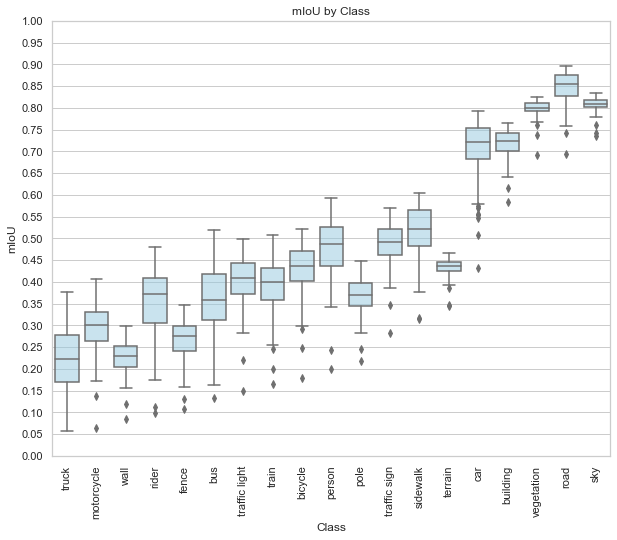

In [4]:
sns.set(style="whitegrid")
plot = sns.boxplot(x='class',
                   y='value',
                   data=iou_df, color="skyblue")

fig = plot.get_figure()

for patch in plot.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .5))

plot.set_yticks(np.linspace(0, 1, num=21))

plot.set_xlabel('Class')
plot.set_ylabel('mIoU')
plot.set_title('mIoU by Class')
for tick in plot.get_xticklabels():
    tick.set_rotation(90)

In [8]:
#train_cols = ['model_depth', 'model_residual_units', 'model_width', 'model_width_ratio', 'model_activation', "class", "image"]
train_cols = ['depth', 'residual_units', 'width', 'width_ratio', 'activation', 'class']
label = "value"

X = iou_df[train_cols]
y = iou_df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


In [ ]:
feature_types = ['categorical'] * len(train_cols)

ebm = ExplainableBoostingRegressor(
    feature_names=train_cols,
    feature_types=feature_types,
    # Overall
    n_jobs=os.cpu_count(),
    random_state=random_state,
)
ebm.fit(X_train, y_train)
ebm.score(X_test, y_test)

0.1960941183868038

In [7]:
ebm_global = ebm.explain_global(name="IoU Predictor")
ebm_local = ebm.explain_local(X_test, y_test, name="Local IoU Predictor")
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show([ebm_perf, ebm_local, ebm_global], share_tables=True)

<!-- http://127.0.0.1:7001/1652227748872/ -->
 Open in new window